<h1 align="center">GRU</h1>

In [13]:
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("khopilot/km-tokenizer-khmer")

# print(tokenizer.special_tokens_map)


In [14]:
import os
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer
from tqdm import tqdm

In [15]:
# 1. HYPERPARAMETERS

TXT_PATH = r"D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\dataset\cleaned_txt\clean_khmer.txt"

MAX_LEN = 50
BATCH_SIZE = 32
EMBED_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 1

LEARNING_RATE = 1e-3
EPOCHS = 30

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_DIR = "D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\Trained_Model\GRU"



In [16]:

# 2. LOAD DATA


def load_sentences(path):
    sentences = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                sentences.append(line)
    return sentences

sentences = load_sentences(TXT_PATH)
print(f"Loaded {len(sentences)} sentences")



Loaded 39558 sentences


In [17]:
# 3. LOAD PRETRAINED KHMER TOKENIZER


tokenizer = AutoTokenizer.from_pretrained("khopilot/km-tokenizer-khmer")

# Tokenize sentences
encoded_ids = tokenizer(
    sentences,
    padding="max_length",
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)["input_ids"]


In [18]:
# 4. DATASET (NEXT-TOKEN PREDICTION)

class LanguageModelDataset(Dataset):
    def __init__(self, input_ids):
        self.input_ids = input_ids

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        x = self.input_ids[idx][:-1]   # input tokens
        y = self.input_ids[idx][1:]    # target tokens
        return x, y

dataset = LanguageModelDataset(encoded_ids)


In [19]:
# 5. TRAIN / VAL / TEST SPLIT


train_size = int(TRAIN_RATIO * len(dataset))
val_size = int(VAL_RATIO * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)




In [20]:
# 6. GRU LANGUAGE MODEL

class GRULanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size,
            embed_dim,
            padding_idx=tokenizer.pad_token_id
        )
        self.gru = nn.GRU(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)      # (B, T, E)
        out, _ = self.gru(x)       # (B, T, H)
        logits = self.fc(out)      # (B, T, V)
        return logits

model = GRULanguageModel(
    vocab_size=tokenizer.vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS
).to(DEVICE)



In [21]:
# 7. LOSS FUNCTION & OPTIMIZER

criterion = nn.CrossEntropyLoss(
    ignore_index=tokenizer.pad_token_id
)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE
)




In [22]:
# 8. EVALUATION METRICS

def top5_accuracy(logits, targets):
    with torch.no_grad():
        top5 = logits.topk(5, dim=-1).indices
        correct = (top5 == targets.unsqueeze(-1)).any(dim=-1)
        mask = targets != tokenizer.pad_token_id
        return (correct & mask).sum().item() / mask.sum().item()


In [23]:

# 9. TRAINING LOOP

train_losses, val_losses = [], []
train_ppls, val_ppls = [], []
train_top5, val_top5 = [], []

for epoch in range(EPOCHS):

    # ---------------- TRAIN ----------------
    model.train()
    total_loss = 0
    total_top5 = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)

        loss = criterion(
            logits.view(-1, logits.size(-1)),
            y.view(-1)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_top5 += top5_accuracy(logits, y)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_top5 = total_top5 / len(train_loader)

    train_losses.append(avg_train_loss)
    train_ppls.append(math.exp(avg_train_loss))
    train_top5.append(avg_train_top5)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_top5_acc = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)

            loss = criterion(
                logits.view(-1, logits.size(-1)),
                y.view(-1)
            )

            val_loss += loss.item()
            val_top5_acc += top5_accuracy(logits, y)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_top5 = val_top5_acc / len(val_loader)

    val_losses.append(avg_val_loss)
    val_ppls.append(math.exp(avg_val_loss))
    val_top5.append(avg_val_top5)

    print(
        f"Epoch {epoch+1} | "
        f"Train Loss: {avg_train_loss:.4f}, "
        f"Val Loss: {avg_val_loss:.4f}, "
        f"Train PPL: {math.exp(avg_train_loss):.2f}, "
        f"Val PPL: {math.exp(avg_val_loss):.2f}, "
        f"Val Top-5: {avg_val_top5:.4f}"
    )


Epoch 1 [Val]: 100%|██████████| 124/124 [00:00<00:00, 183.48it/s]


Epoch 1 | Train Loss: 5.4348, Val Loss: 4.5927, Train PPL: 229.25, Val PPL: 98.76, Val Top-5: 0.4167


Epoch 2 [Val]: 100%|██████████| 124/124 [00:00<00:00, 180.41it/s]


Epoch 2 | Train Loss: 4.0624, Val Loss: 4.0871, Train PPL: 58.11, Val PPL: 59.56, Val Top-5: 0.4912


Epoch 3 [Val]: 100%|██████████| 124/124 [00:00<00:00, 185.35it/s]


Epoch 3 | Train Loss: 3.4294, Val Loss: 3.8803, Train PPL: 30.86, Val PPL: 48.44, Val Top-5: 0.5258


Epoch 4 [Val]: 100%|██████████| 124/124 [00:00<00:00, 186.86it/s]


Epoch 4 | Train Loss: 2.9982, Val Loss: 3.7936, Train PPL: 20.05, Val PPL: 44.42, Val Top-5: 0.5427


Epoch 5 [Val]: 100%|██████████| 124/124 [00:00<00:00, 187.88it/s]


Epoch 5 | Train Loss: 2.6762, Val Loss: 3.7663, Train PPL: 14.53, Val PPL: 43.22, Val Top-5: 0.5535


Epoch 6 [Val]: 100%|██████████| 124/124 [00:00<00:00, 182.13it/s]


Epoch 6 | Train Loss: 2.4260, Val Loss: 3.7731, Train PPL: 11.31, Val PPL: 43.52, Val Top-5: 0.5592


Epoch 7 [Val]: 100%|██████████| 124/124 [00:00<00:00, 186.24it/s]


Epoch 7 | Train Loss: 2.2250, Val Loss: 3.7918, Train PPL: 9.25, Val PPL: 44.33, Val Top-5: 0.5625


Epoch 8 [Val]: 100%|██████████| 124/124 [00:00<00:00, 188.25it/s]


Epoch 8 | Train Loss: 2.0672, Val Loss: 3.8385, Train PPL: 7.90, Val PPL: 46.46, Val Top-5: 0.5663


Epoch 9 [Val]: 100%|██████████| 124/124 [00:00<00:00, 183.96it/s]


Epoch 9 | Train Loss: 1.9391, Val Loss: 3.8776, Train PPL: 6.95, Val PPL: 48.31, Val Top-5: 0.5683


Epoch 10 [Val]: 100%|██████████| 124/124 [00:00<00:00, 184.35it/s]


Epoch 10 | Train Loss: 1.8316, Val Loss: 3.9473, Train PPL: 6.24, Val PPL: 51.80, Val Top-5: 0.5672


Epoch 11 [Val]: 100%|██████████| 124/124 [00:00<00:00, 183.53it/s]


Epoch 11 | Train Loss: 1.7465, Val Loss: 3.9977, Train PPL: 5.73, Val PPL: 54.47, Val Top-5: 0.5684


Epoch 12 [Val]: 100%|██████████| 124/124 [00:00<00:00, 186.88it/s]


Epoch 12 | Train Loss: 1.6730, Val Loss: 4.0546, Train PPL: 5.33, Val PPL: 57.66, Val Top-5: 0.5677


Epoch 13 [Val]: 100%|██████████| 124/124 [00:00<00:00, 178.90it/s]


Epoch 13 | Train Loss: 1.6125, Val Loss: 4.1094, Train PPL: 5.02, Val PPL: 60.91, Val Top-5: 0.5691


Epoch 14 [Val]: 100%|██████████| 124/124 [00:00<00:00, 184.67it/s]


Epoch 14 | Train Loss: 1.5621, Val Loss: 4.1697, Train PPL: 4.77, Val PPL: 64.70, Val Top-5: 0.5663


Epoch 15 [Val]: 100%|██████████| 124/124 [00:00<00:00, 187.04it/s]


Epoch 15 | Train Loss: 1.5248, Val Loss: 4.2300, Train PPL: 4.59, Val PPL: 68.72, Val Top-5: 0.5647


Epoch 16 [Val]: 100%|██████████| 124/124 [00:00<00:00, 182.63it/s]


Epoch 16 | Train Loss: 1.4876, Val Loss: 4.2721, Train PPL: 4.43, Val PPL: 71.67, Val Top-5: 0.5665


Epoch 17 [Val]: 100%|██████████| 124/124 [00:00<00:00, 184.96it/s]


Epoch 17 | Train Loss: 1.4578, Val Loss: 4.3217, Train PPL: 4.30, Val PPL: 75.32, Val Top-5: 0.5686


Epoch 18 [Val]: 100%|██████████| 124/124 [00:00<00:00, 186.39it/s]


Epoch 18 | Train Loss: 1.4312, Val Loss: 4.3740, Train PPL: 4.18, Val PPL: 79.36, Val Top-5: 0.5667


Epoch 19 [Val]: 100%|██████████| 124/124 [00:00<00:00, 182.64it/s]


Epoch 19 | Train Loss: 1.4123, Val Loss: 4.4193, Train PPL: 4.11, Val PPL: 83.04, Val Top-5: 0.5670


Epoch 20 [Val]: 100%|██████████| 124/124 [00:00<00:00, 188.51it/s]


Epoch 20 | Train Loss: 1.3921, Val Loss: 4.4737, Train PPL: 4.02, Val PPL: 87.68, Val Top-5: 0.5665


Epoch 21 [Val]: 100%|██████████| 124/124 [00:00<00:00, 186.59it/s]


Epoch 21 | Train Loss: 1.3799, Val Loss: 4.5174, Train PPL: 3.97, Val PPL: 91.59, Val Top-5: 0.5674


Epoch 22 [Val]: 100%|██████████| 124/124 [00:00<00:00, 179.78it/s]


Epoch 22 | Train Loss: 1.3688, Val Loss: 4.5533, Train PPL: 3.93, Val PPL: 94.95, Val Top-5: 0.5661


Epoch 23 [Val]: 100%|██████████| 124/124 [00:00<00:00, 187.82it/s]


Epoch 23 | Train Loss: 1.3534, Val Loss: 4.6046, Train PPL: 3.87, Val PPL: 99.94, Val Top-5: 0.5655


Epoch 24 [Val]: 100%|██████████| 124/124 [00:00<00:00, 181.99it/s]


Epoch 24 | Train Loss: 1.3482, Val Loss: 4.6405, Train PPL: 3.85, Val PPL: 103.60, Val Top-5: 0.5646


Epoch 25 [Val]: 100%|██████████| 124/124 [00:00<00:00, 189.02it/s]


Epoch 25 | Train Loss: 1.3407, Val Loss: 4.6685, Train PPL: 3.82, Val PPL: 106.54, Val Top-5: 0.5646


Epoch 26 [Val]: 100%|██████████| 124/124 [00:00<00:00, 186.49it/s]


Epoch 26 | Train Loss: 1.3317, Val Loss: 4.7052, Train PPL: 3.79, Val PPL: 110.53, Val Top-5: 0.5634


Epoch 27 [Val]: 100%|██████████| 124/124 [00:00<00:00, 186.12it/s]


Epoch 27 | Train Loss: 1.3260, Val Loss: 4.7495, Train PPL: 3.77, Val PPL: 115.52, Val Top-5: 0.5632


Epoch 28 [Val]: 100%|██████████| 124/124 [00:00<00:00, 183.56it/s]


Epoch 28 | Train Loss: 1.3275, Val Loss: 4.7794, Train PPL: 3.77, Val PPL: 119.04, Val Top-5: 0.5637


Epoch 29 [Val]: 100%|██████████| 124/124 [00:00<00:00, 183.70it/s]


Epoch 29 | Train Loss: 1.3252, Val Loss: 4.8139, Train PPL: 3.76, Val PPL: 123.22, Val Top-5: 0.5646


Epoch 30 [Val]: 100%|██████████| 124/124 [00:00<00:00, 186.93it/s]

Epoch 30 | Train Loss: 1.3226, Val Loss: 4.8429, Train PPL: 3.75, Val PPL: 126.84, Val Top-5: 0.5619


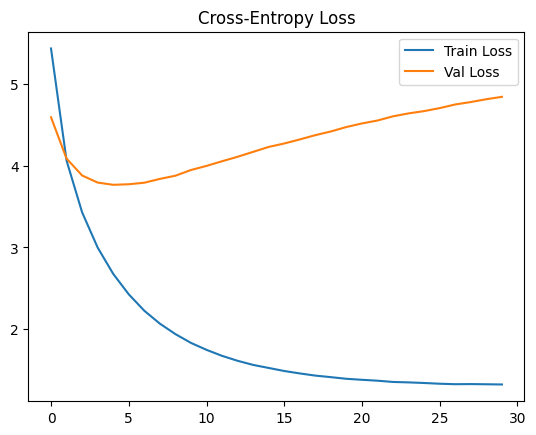

In [24]:
# 10. PLOT RESULTS


plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Cross-Entropy Loss")
plt.show()



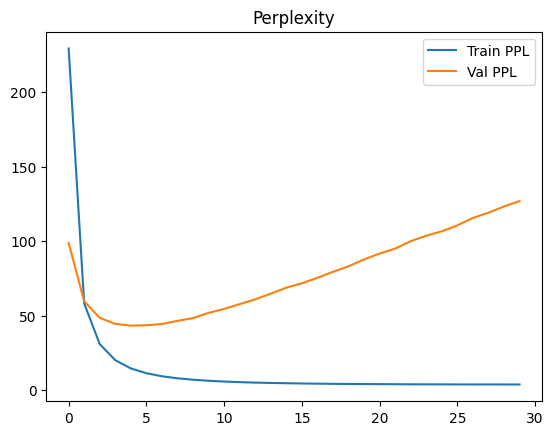

In [25]:
plt.figure()
plt.plot(train_ppls, label="Train PPL")
plt.plot(val_ppls, label="Val PPL")
plt.legend()
plt.title("Perplexity")
plt.show()

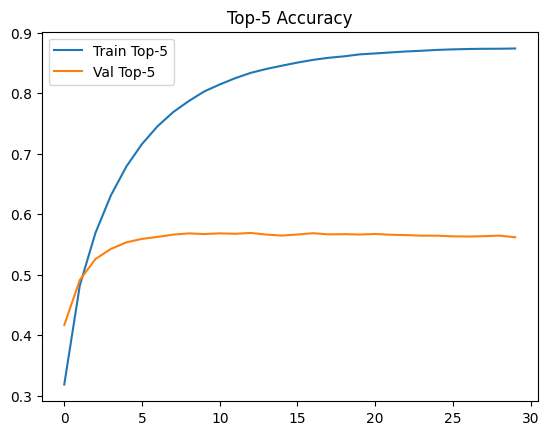

In [26]:

plt.figure()
plt.plot(train_top5, label="Train Top-5")
plt.plot(val_top5, label="Val Top-5")
plt.legend()
plt.title("Top-5 Accuracy")
plt.show()

In [27]:
# 11. TEST EVALUATION

model.eval()
test_loss = 0
test_top5 = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)

        loss = criterion(
            logits.view(-1, logits.size(-1)),
            y.view(-1)
        )

        test_loss += loss.item()
        test_top5 += top5_accuracy(logits, y)

test_loss /= len(test_loader)
test_top5 /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Perplexity: {math.exp(test_loss):.2f}")
print(f"Test Top-5 Accuracy: {test_top5:.4f}")


===== TEST RESULTS =====
Test Loss: 4.7684
Test Perplexity: 117.73
Test Top-5 Accuracy: 0.5696


In [28]:
# 12. SAVE MODEL & TOKENIZER 


os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(model.state_dict(), f"{SAVE_DIR}/gru_lm.pt")
tokenizer.save_pretrained(SAVE_DIR)

print(f"\nModel and tokenizer saved to: {SAVE_DIR}")



Model and tokenizer saved to: D:\AMS_Year5\Semester_1\TP_IWR\Khmer-Text-Prediction\Trained_Model\GRU
